In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pylab as pl
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets
import random
import scipy.optimize
from scipy.interpolate import interp1d
import pandas as pd
from tqdm.notebook import tqdm_notebook as tqdm
import seaborn as sns
from matplotlib.colors import rgb2hex
import numba
from scipy import interpolate

from numba.core import types
from numba.typed import Dict
import emcee

import sys
sys.path.append('../')
from functions import *

In [25]:
show_details = False

In [26]:
def CL_cdf_fun(L_contour, offset, amplitude, sigma, num_sites, distribution='step'):
    x_ls = np.linspace(0,L_contour,num_sites)
    dx = x_ls[1] - x_ls[0]
    pdf_ls=[]

    dx_site = L_contour/num_sites
    
    if distribution == 'step':
        for x in x_ls:
            if x < sigma:
                pdf = amplitude + offset
            elif x >= sigma:
                pdf = offset 
            
            if pdf*dx_site > 1:
                raise ValueError('# crosslinkers exceeded # binding sites available!')
        
            pdf_ls.append(pdf)
    
    elif distribution == 'gaussian':
        for x in x_ls:
            pdf = offset+amplitude*np.exp(-x**2/(2*sigma**2))
            pdf_ls.append(pdf)
    
            if pdf*dx_site > 1:
                raise ValueError('# crosslinkers exceeded # binding sites available!')
    
    cdf_ls = np.cumsum(pdf_ls)*dx
            
    return x_ls, cdf_ls


def CL_pos_fn(L_contour, num_sites, CL_tot, amp2offset, sigma, distribution, spacing='deterministic'):
    
    if distribution == 'gaussian':
        G = np.sqrt(np.pi/2)*sigma/L_contour*scipy.special.erf(L_contour/np.sqrt(2*sigma**2))
        CL_avg = CL_tot/L_contour
        offset = CL_avg/(1+amp2offset*G)
        amplitude = amp2offset*offset        
    elif distribution == 'step':
        offset = CL_tot/(L_contour+(amp2offset*sigma))
        amplitude = amp2offset*offset        

    x_ls,cdf_ls = CL_cdf_fun(L_contour, offset, amplitude, sigma, num_sites, distribution)

    if spacing == 'random':
        re_x_ls = np.zeros(CL_tot)
        for i in range(CL_tot):
            re = np.random.rand()*cdf_ls[-1]
            re = np.max([re,cdf_ls[0]])
            ind = np.where(cdf_ls <= re)[-1][-1]
            re_x_ls[i] = x_ls[ind]
        re_x_ls = np.unique(re_x_ls)

    elif spacing == 'deterministic':
        cdf_interp = interp1d(x_ls,cdf_ls)
        ecdf = 0
        dx = L_contour/num_sites
        x_curr = 0
        re_x_ls = []
        while x_curr <= L_contour-dx and ecdf < CL_tot:
            if ecdf+1 < cdf_interp(x_curr+dx):
                re_x_ls.append(x_curr+dx)
                ecdf += 1
            x_curr += dx
        re_x_ls = np.array(re_x_ls)
    return np.sort(re_x_ls)

        
def deflection_CL_density(param, L_contour, Fy, xF, CL_pos, CL_kv, num_sites, n_points=1000):
    
    # deflection function when external force is exerted on a steady-state k-fiber
    # and crosslinking to environment is engaged

    Ry, theta0 = param
    
    ds = L_contour/(n_points - 1)
    
    x_ls = np.zeros(n_points)
    y_ls = np.zeros(n_points)
    
    slope_ls = np.zeros(n_points)
    slope_ls[0] = np.tan(theta0)
    
    def dx_fn(slope):
        return ds/np.sqrt(1+slope**2)
    
    dx_ls = np.zeros(n_points)
    dx_ls[0] = dx_fn(slope_ls[0])
    
    M_ls = np.zeros(n_points)

    fCLy = 0
    Mfy = 0

    dx_site = L_contour/num_sites
    ind_curr = 0
    for i in range(1,n_points):            
        
        # Midpoint method
        if i>1:
            y_fn = interp1d(x_ls[i-2:i],y_ls[i-2:i])
#             CL_pos_i = CL_pos[(CL_pos >= x_ls[i-2]) & (CL_pos < x_ls[i-1])]
            
            ############
            dn = int((x_ls[i-1] - x_ls[i-2])/dx_site) + 1
            CL_pos_i_ls = []
            
            num_accepted = 0
            for j in range(ind_curr, np.min([ind_curr+dn,len(CL_pos)])):
                if CL_pos[j] < x_ls[i-1] and CL_pos[j] >= x_ls[i-2]:
                    CL_pos_i_ls.append(CL_pos[j])
                    num_accepted += 1

                else:
                    break
            ind_curr += num_accepted
            CL_pos_i_ls = np.array(CL_pos_i_ls)
#             print(CL_pos_i_ls)
            dfy = np.sum(CL_kv*y_fn(CL_pos_i_ls)) # downward pointing force
            fCLy += dfy
            Mfy -= np.sum(dfy*CL_pos_i_ls)            

        Mf = fCLy*x_ls[i-1] + Mfy 
        M = - Ry*x_ls[i-1] + Mf
        
        if x_ls[i-1] > xF:
            M = M - Fy*(x_ls[i-1]-xF) 
            
        dx = dx_fn(slope_ls[i-1])
        slope_mid = slope_ls[i-1] - dx/2*M * (1+slope_ls[i-1]**2)**1.5
        
        slope_mid = np.sign(slope_mid)*np.min([np.abs(slope_mid), 100])
        dx = dx_fn(slope_mid)
        
        y_mid = y_ls[i-1] + dx/2*slope_mid
        x_mid = x_ls[i-1] + dx/2
                     
        Mf_mid = fCLy*x_mid + Mfy          
        M_mid = - Ry*x_mid + Mf_mid
        
        if x_mid > xF:
            M_mid = M_mid - Fy*(x_mid-xF) 

        M_ls[i] = M_mid
        
        dx_ls[i] = dx
        slope_ls[i] = slope_ls[i-1] - dx*M_mid * (1+slope_mid**2)**1.5
        slope_ls[i] = np.sign(slope_ls[i])*np.min([np.abs(slope_ls[i]), 100])
        x_ls[i] = x_ls[i-1] + dx
        y_ls[i] = y_ls[i-1] + dx*slope_mid
    
    if xF > x_ls[-1]:
        Ky = -(Ry - fCLy) # vertical force at the kinetochore
    else:
        Ky = -(Fy + Ry - fCLy) # vertical force at the kinetochore

    deflection_output = {"x_ls": x_ls, 
                         "y_ls": y_ls,
                         "M_ls": M_ls,
                         "Ky": Ky,
                         "fCLy":fCLy, 
                         "slope_ls": slope_ls}
    
    return deflection_output

def error_CL_density(param, L_contour, Fy, xF, CL_pos, CL_kv, num_sites):
    deflection_output = deflection_CL_density(param, L_contour, Fy, xF, CL_pos, CL_kv, num_sites)

    M_ls, y_ls = [deflection_output[key] for key in ["M_ls", "y_ls"]]
    
    M_right = M_ls[-1]
    y_right = y_ls[-1]
    error = abs(M_right)**2 + abs(y_right)**2
    return error

def give_param_opt(param_init, args):
    output = scipy.optimize.minimize(error_CL_density, param_init, args, method="Nelder-Mead", tol=1e-9)
    if output.fun > 1e-3:
        raise Exception("Optimum not found!!")
    param_opt = output.x
    return param_opt

In [27]:
def CL_simulation(Fy, xF, L_contour, num_sites, CL_tot, amp2offset, sigma, CL_kv, distribution, spacing):

    CL_pos = CL_pos_fn(L_contour, num_sites, CL_tot, amp2offset, sigma, distribution, spacing)    
        
    keys = ["x_ls", "y_ls", "M_ls", "Ky", "fCLy", "slope_ls"]
    
    F_low = 0.001
    Ry, theta0 = np.array([1e-3, 1e-3])
    Fy_ls = np.concatenate(([F_low], np.logspace(np.log10(F_low), np.log10(Fy), 10)))
    
    force_reduced = False
    
    rescale_Ry = Fy_ls[2]/Fy_ls[1]
    rescale_theta0 = Fy_ls[2]/Fy_ls[1]
    
    for i in tqdm(range(1, len(Fy_ls))):
        Ry = Ry * rescale_Ry
        theta0 = theta0 * rescale_theta0
        
        try:
            Fy = Fy_ls[i]
            args = (L_contour, Fy, xF, CL_pos, CL_kv, num_sites)
            [Ry, theta0] = give_param_opt([Ry, theta0], args)
        except Exception:
            Fy = Fy_ls[i-1]
            Ry /= rescale_Ry
            theta0 /= rescale_theta0
            
            args = (L_contour, Fy, xF, CL_pos, CL_kv, num_sites)
            [Ry, theta0] = give_param_opt([Ry, theta0], args)
            force_reduced = True
            
        if i > 1:
            rescale_Ry = Ry/Ry_prime
            rescale_theta0 = theta0/theta0_prime
        Ry_prime = Ry
        theta0_prime = theta0
        
        deflection_output = deflection_CL_density([Ry, theta0], L_contour, Fy, xF, CL_pos, CL_kv, num_sites)
        x_ls, y_ls, M_ls, Ky, fCLy, slope_ls = [deflection_output[key] for key in keys]
        
        if force_reduced:
            print('Force got reduced to ' + str(Fy))
            break
    return x_ls, y_ls, M_ls, Ky, fCLy, slope_ls, CL_pos, Fy, Ry, theta0

def plot_profile_fn(x_ls, y_ls, M_ls, Fy, xF, CL_pos, CL_plotting_freq):
    plt.plot(x_ls,y_ls, color='k', lw=5, zorder=2)

    index_star = M_ls==M_ls[x_ls<xF].min()
    plt.scatter(x_ls[index_star], y_ls[index_star], marker="*",s=300, zorder=10,color="red",edgecolor="k")

    # bins = 200
    # plt.hist(CL_pos, bins, alpha=0.5, weights=[np.max(y_ls)/CL_tot*(bins/5)]*len(CL_pos))#, cumulative=True)
    y_interp = interp1d(x_ls,y_ls)
    for i in range(0,len(CL_pos),CL_plotting_freq):
        if CL_pos[i] <= x_ls[-1]:
            plt.plot([CL_pos[i],CL_pos[i]],[0,y_interp(CL_pos[i])], color='lightgray', zorder=1)

#     plt.plot(x_ls, M_ls, color='royalblue')

    plt.quiver(xF,y_interp(xF), 0,Fy,color='gold',scale=10,zorder=3)

#     plt.axvline(xF,color='k', ls='--')
    plt.axhline(0,color='k', ls='--')
    plt.axvline(0,color='k', ls='--')
    plt.ylim(-np.max(y_ls)*0.5,np.max(y_ls)*2)
    plt.xlim(-0.5,10.5)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
#     plt.axis("equal")
    plt.tight_layout()
    plt.show()

# def plot_CLdist_fn(x_ls, CL_pos, CL_plotting_freq):
#     for ind in range(0,len(CL_pos),CL_plotting_freq):
#         if CL_pos[ind] <= x_ls[-1]:
#             plt.plot([CL_pos[ind],CL_pos[ind]],[0,1], color='lightgray', zorder=1)

#     plt.xlabel("Position along k-fiber")
#     plt.ylabel("CL distribution")
#     plt.axvline(sigma, color='grey', ls = '--')
#     plt.ylim(0,2)
#     plt.xlim(-0.5,10.5)
#     plt.tight_layout()
#     plt.show()

In [28]:
def curvature(x_path, y_path, scale):
    r, xcs, ycs = [],[],[]
    num_points = len(x_path)

    for i in range(int(scale),int(num_points-scale)):
        x1 = x_path[i-int(scale)]
        y1 = y_path[i-int(scale)]
        x2 = x_path[i]
        y2 = y_path[i]
        x3 = x_path[i+int(scale)]
        y3 = y_path[i+int(scale)]
        
        ma = (y2 - y1)/(x2 - x1)
        mb = (y3 - y2)/(x3 - x2)
        xc = (ma*mb*(y1 - y3) + mb*(x1 + x2) - ma*(x2 + x3))/(2*(mb - ma))
        yc = -1/ma*(xc - (x1 + x2)/2) + (y1 + y2)/2

        if ma == mb:
            rad = float(np.inf)
        else:
            rad = float(np.hypot(xc - x1, yc - y1))

        nv1 = np.cross(np.array([x2 - x1, y2 - y1, 0]), np.array([0 ,0, 1]))
        nv2 = np.cross(np.array([x3 - x2, y3 - y2, 0]), np.array([0 ,0, 1]))
        nv = np.average([nv1, nv2], axis = 0)
        align = -np.sign(np.dot(nv[0:2], np.array([x2 - xc, y2 - yc])))

        if rad == 0:
            r.append(np.nan)
        else:
            r.append(align * 1./rad)
            
        xcs.append(xc)
        ycs.append(yc)

    return r

In [55]:
float_array = types.float64[:]
float_val = types.float64

@numba.njit
def deflection_exact_FC(param, x_dat, y_dat, Mk_zero = False, n_div=100):
    Fx, Mk, Fy, theta0, Fext, xF, xC, FC = param
    
    if Mk_zero:
        Mk = 0
    
    s_dat_ls, L_contour = contour_fn(x_dat, y_dat)
    ds = L_contour/n_div
    n_steps = int(1.15*n_div)
    
    
    x_ls = np.zeros(n_steps, dtype=np.float64)
    y_ls = np.zeros(n_steps)
    M_ls = np.zeros(n_steps)
    theta_ls = np.zeros(n_steps)
    
    
    theta_ls[0] = theta0
    found_F = False
    yF = 0
    Fext_x = 0
    Fext_y = Fext
    thetaF = np.pi/2
    
    for i in range(n_steps-1):
 
        xF_sign = np.sign(xF) * np.sign(xF - x_ls[i])
        if xF_sign < 0 and found_F == False:
            found_F = True
            
            iF = i-1
            yF = interpolate_two_pt(xF, x_ls[iF], x_ls[iF+1], y_ls[iF], y_ls[iF+1])
            thetaF = np.pi/2 + np.arctan2(y_ls[iF+1]-y_ls[iF], x_ls[iF+1]-x_ls[iF])
            Fext_x = Fext * np.cos(thetaF)
            Fext_y = Fext * np.sin(thetaF)
            
            
        M = Mk + Fx*y_ls[i] - Fy*x_ls[i]
        if found_F:
            M += Fext_x*(y_ls[i]-yF) - Fext_y*(x_ls[i]-xF)
        if x_ls[i] >= xC:
            M -= FC*(xC-x_ls[i]) 
        
        
        theta_mid = theta_ls[i] - ds/2*M
        y_mid = y_ls[i] + ds/2*np.sin(theta_mid)
        x_mid = x_ls[i] + ds/2*np.cos(theta_mid)
        
        
        M_mid = Mk + Fx*y_mid - Fy*x_mid
        if found_F:
            M_mid += Fext_x*(y_mid-yF) - Fext_y*(x_mid-xF)
        if x_mid >= xC:
            M_mid -= FC*(xC-x_mid) 
            
            
        theta_ls[i+1] = theta_ls[i] - ds*M_mid
        x_ls[i+1] = x_ls[i] + ds*np.cos(theta_mid)
        y_ls[i+1] = y_ls[i] + ds*np.sin(theta_mid)
        M_ls[i+1] = M_mid 
    
    
    deflect_arrays = Dict.empty(
        key_type=types.unicode_type,
        value_type=float_array
    )
    
    deflect_numbers = Dict.empty(
        key_type=types.unicode_type,
        value_type=float_val
    )
    
    deflect_arrays['x_mod'] = x_ls.astype(np.float64)
    deflect_arrays['y_mod'] = y_ls.astype(np.float64)
    deflect_arrays['theta_mod'] = theta_ls.astype(np.float64)
    deflect_arrays['M_mod'] = M_ls.astype(np.float64)
    
    deflect_numbers['Fext_x'] = np.float64(Fext_x)
    deflect_numbers['Fext_y'] = np.float64(Fext_y)
    deflect_numbers['xF'] = np.float64(xF)
    deflect_numbers['yF'] = np.float64(yF)
    deflect_numbers['thetaF'] = np.float64(thetaF)
    
    return deflect_arrays, deflect_numbers

@numba.njit
def find_loops(x_mod, y_mod):
    ds = np.sqrt((x_mod[1]-x_mod[0])**2 + (y_mod[1]-y_mod[0])**2)
    x_mod_mat_1, x_mod_mat_2 = mesh_jit(x_mod, x_mod)
    y_mod_mat_1, y_mod_mat_2 = mesh_jit(y_mod, y_mod)

    ii, jj = mesh_jit(np.arange(len(x_mod)), np.arange(len(x_mod)))
    
    d_pairwise_mat = np.sqrt((x_mod_mat_1-x_mod_mat_2)**2 + (y_mod_mat_1-y_mod_mat_2)**2)
    
    width = np.array([0.04*len(x_mod), 2.2]).max()
    coord_diff = np.abs(ii-jj)
    ind_far = np.where((coord_diff.ravel() > width) & (coord_diff.ravel() < len(x_mod)-width))
    
    dd = d_pairwise_mat.ravel()[ind_far]
    
    loop_exists = (np.sum(dd < 2*ds) > 0)
    
    return loop_exists

@numba.njit
def res_fn_exact(param, x_dat, y_dat, Mk_zero = False):
    
    deflect_arrays, deflect_numbers = deflection_exact_FC(param, x_dat, y_dat, Mk_zero=Mk_zero)
    
    x_mod = deflect_arrays["x_mod"]
    y_mod = deflect_arrays["y_mod"]
    
    res = distances_pair_min_new(x_dat, y_dat, x_mod, y_mod)
    
    return res

@numba.njit
def logpost_exact(param, x_dat, y_dat, x_peak, sigma_xF, Mk_zero=False, end_to_end=np.inf):
    
    Fx, Mk, Fy, theta0, Fext, xF, xC, FC = param
    
    
    deflect_arrays, deflect_numbers = deflection_exact_FC(param, x_dat, y_dat, Mk_zero=Mk_zero)
    x_mod = deflect_arrays["x_mod"]
    y_mod = deflect_arrays["y_mod"]
    theta_ls = deflect_arrays["theta_mod"]
    Fext_x = deflect_numbers["Fext_x"]
    Fext_y = deflect_numbers["Fext_y"]
    M_mod = deflect_arrays["M_mod"]
    
    L = x_dat[-1]-x_dat[0]
  
    if (Fext_x > 0) and (Fx > 0):
        return -np.inf

    if (Fext_x < 0) and (Fx+Fext_x > 0):
        return -np.inf
    
    
    if Fext < 0:
        return -np.inf
    
    
    if np.abs(xF-x_peak) > sigma_xF:
        return -np.inf
    
    if xC < 0 or xC > xF:
        return -np.inf
    
    
    if FC < 0 or FC > 5:
        return -np.inf
    
    if np.abs(Mk) > 1e1:
        return -np.inf
    
    
    s_mod, _ = contour_fn(x_mod, y_mod)
    _, L_contour = contour_fn(x_dat, y_dat)
    x_mod_truncated = x_mod[s_mod <= 0.8*L_contour]
    y_mod_truncated = y_mod[s_mod <= 0.8*L_contour]
    
    loop_exists = find_loops(x_mod_truncated, y_mod_truncated)
    if loop_exists:
        return -np.inf
    
    
    if np.sum( theta_ls[s_mod <= 0.9*L_contour] > np.pi/2 ) > 0:
        return -np.inf
    
    res = res_fn_exact(param, x_dat, y_dat, Mk_zero)
    
    penalty_end_match = 1+(res[-1]/end_to_end)**2

    penalty_Mp = 1
    if M_mod[-1] < 0.0:
        penalty_Mp = 1+(M_mod[-1]/0.01)**2
    
    
    return -10*( np.log(np.sum(res**2)) + np.log(penalty_end_match) + np.log(penalty_Mp))

def give_top_chain(df_mcmc, n_dim, n_keep):
    chains_all = df_mcmc['chain'].values
    chains_unique = np.unique(df_mcmc['chain'].values)
    lnprob = df_mcmc['lnprob'].values

    lnprob_max = []
    for chain in chains_unique:
        lnprob_chain = lnprob[chains_all == chain]
        lnprob_max.append(np.max(lnprob_chain))
    lnprob_max = np.array(lnprob_max)
    
    ind_top = np.where(np.argsort(lnprob_max) >= len(lnprob_max)-n_keep)
    chains_select = chains_unique[ind_top]
    lnprob_select = lnprob_max[ind_top]
    
    p_init_select = []
    for i, chain in enumerate(chains_select):
        eps = 1e-2*np.random.rand(n_dim)
        df_set = df_mcmc.loc[df_mcmc['chain']==chain]
        df_row = df_set.loc[df_set['lnprob']==lnprob_select[i]].iloc[[0]]
        p_init_select.append(df_row.values[0][0:-2] + eps)
    p_init_select = np.array(p_init_select)
    
    return p_init_select

In [56]:
df_new = pd.DataFrame()
df = pd.read_pickle("discreteCL_modeling.pkl")

In [74]:
# df_param_inference_locsigma = pd.DataFrame(columns = ["L_contour", "Fy", "xF", "num_sites", "CL_tot", \
#                                                       "amp2offset", "sigma", "CL_kv", "distribution", \
#                                                       "spacing", "inferred_params"])

#### SIMULATION PARAMETER INPUTS
L_contour = 10
Fy = 1.0
xF_ls = [5,6,7,8,9]
num_sites = 1000
CL_tot = 100
amp2offset = 1e6
sigma_ls = [1,1.5,2,2.5,3]
CL_kv = 0.1 #np.linspace(0,0.1,10)
distribution = 'step'
spacing = 'deterministic' # 'deterministic' or 'random'
sigma_xF = 0.5
colors = pl.cm.Greens(np.linspace(0.15,1,len(sigma_ls)))

sim_run = False
for sigma in sigma_ls:
    for xF in xF_ls:
        df_found = df.loc[(df['L_contour'] == L_contour) & (df['Fy'] == Fy) & (df['xF'] == xF) & (df['num_sites'] == num_sites)
                          & (df['CL_tot'] == CL_tot) & (df['amp2offset'] == amp2offset) & (df['sigma'] == sigma)
                          & (df['CL_kv'] == CL_kv) & (df['distribution'] == distribution) & (df['spacing'] == spacing)]
        if not df_found.empty:
            sim_run = False
#             print("Exists")
        elif df_found.empty:
            sim_run = True
            print("Does not exist. Running...")
            x_ls, y_ls, M_ls, Ky, fCLy, slope_ls, CL_pos, Fy_sim, Ry_sim, theta0_sim = CL_simulation(Fy, xF, L_contour, num_sites, CL_tot,
                                                                                                     amp2offset, sigma, CL_kv, distribution, spacing)

        if sim_run:
            df_new = df_new.append({'L_contour':L_contour,'Fy':Fy,'xF':xF,'num_sites':num_sites,
                                    'CL_tot':CL_tot,'amp2offset': amp2offset,'sigma': sigma,'CL_kv': CL_kv,
                                    'distribution': distribution,'spacing':spacing,
                                    'x_vals':x_ls,'y_vals':y_ls,'M_vals':M_ls,'Ky_val':Ky,'fCLy_val': -fCLy,
                                    'slope_vals':slope_ls,'CL_pos_vals':CL_pos, 'Fy_val':Fy_sim, 'Ry_val':Ry_sim, 
                                    'theta0_val':theta0_sim},ignore_index=True)    

df_new = df_new.drop_duplicates(["L_contour", "Fy", "xF", "num_sites", "CL_tot", "amp2offset",
                               "sigma", "CL_kv", "distribution", "spacing"], ignore_index=True)

df = df.append(df_new, ignore_index=True)
df.to_pickle("discreteCL_modeling.pkl")


sigma = 1


<Figure size 360x360 with 0 Axes>

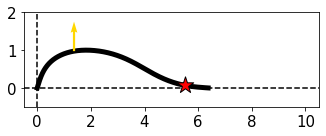

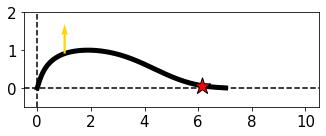

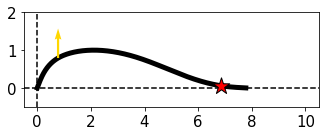

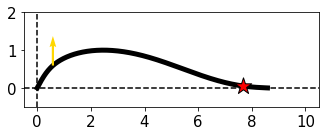

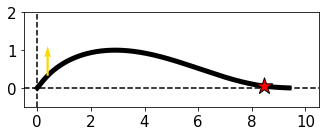

sigma = 1.5


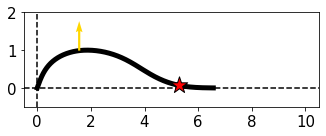

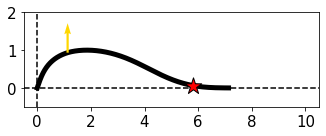

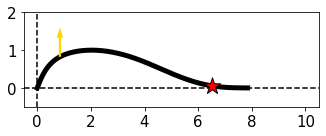

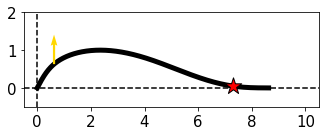

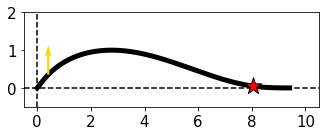

sigma = 2


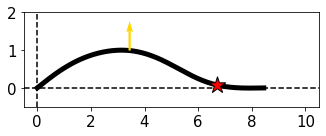

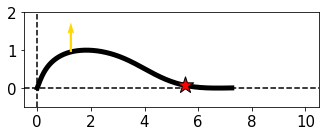

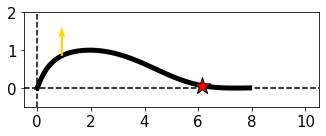

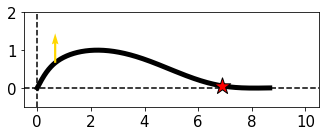

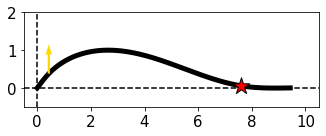

sigma = 2.5


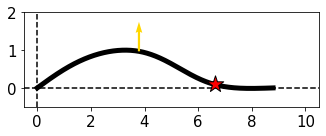

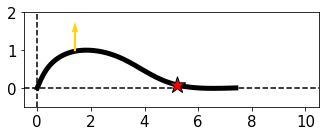

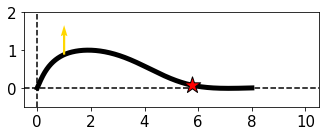

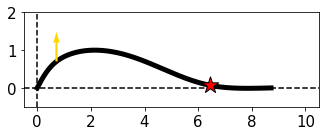

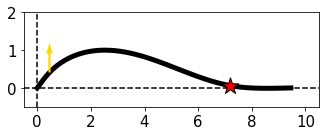

sigma = 3


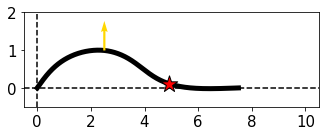

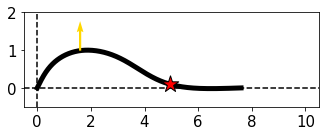

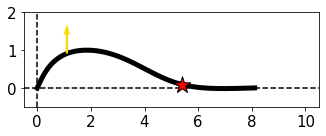

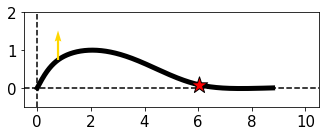

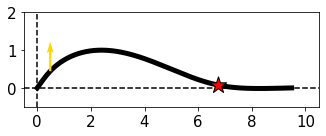

In [75]:
# PLOT RESULTS

kfiber_length_arr = np.zeros(len(xF_ls))
chrom_star_dist_arr = np.zeros(len(xF_ls))
chrom_needle_dist_arr = np.zeros(len(xF_ls))
x_star_array = np.zeros(len(xF_ls)) 
x_star_arrays = []
plt.figure(figsize=(5,5))

for n,sigma in enumerate(sigma_ls):
    print("sigma = %s"%sigma)
    for i,xF in enumerate(xF_ls):
        df_found = df.loc[(df['L_contour'] == L_contour) & (df['Fy'] == Fy) & (df['xF'] == xF) & (df['num_sites'] == num_sites) 
                          & (df['CL_tot'] == CL_tot) & (df['amp2offset'] == amp2offset) & (df['sigma'] == sigma)
                          & (df['CL_kv'] == CL_kv) & (df['distribution'] == distribution) & (df['spacing'] == spacing)]
        x_ls = df_found["x_vals"].values[0]
        y_ls = df_found["y_vals"].values[0]
        M_ls = df_found["M_vals"].values[0]
        CL_pos = df_found["CL_pos_vals"].values[0]  
        
        # flip profile
        L = x_ls[-1] - x_ls[0]
        y_ls = np.flip(y_ls)
        x_ls = L - np.flip(x_ls)
        M_ls = np.flip(M_ls)
        xF = L - xF
        y_interp = interp1d(x_ls,y_ls)
        yF = y_interp(xF)
        
        # Normalize the magnitude of deflection
        y_ls = y_ls / np.max(y_ls)

        # Plot profile
        
        plt.figure(figsize=[5,2])
        plt.plot(x_ls,y_ls, color='k', lw=5, zorder=2)
        index_star = M_ls==M_ls[x_ls>xF].min()
        plt.scatter(x_ls[index_star], y_ls[index_star], marker="*",s=300, zorder=10,color="red",edgecolor="k")
        
        CL_plotting_freq = 10
        y_interp = interp1d(x_ls,y_ls)
        for i in range(0,len(CL_pos),CL_plotting_freq):
            if CL_pos[i] <= x_ls[-1]:
                plt.plot([L - CL_pos[i],L - CL_pos[i]],[0,y_interp(L - CL_pos[i])], color='lightgray', zorder=1)

        plt.quiver(xF,y_interp(xF), 0, Fext_sim,color='gold',scale=10,zorder=3)

        plt.axhline(0,color='k', ls='--')
        plt.axvline(0,color='k', ls='--')
        plt.ylim(-np.max(y_ls)*0.5,np.max(y_ls)*2)
        plt.xlim(-0.5,10.5)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        
        plt.tight_layout()
        plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

1 5


/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 50000/50000 [05:38<00:00, 147.51it/s]


sigma = 1, xF_sim = 5
xC = 2.981148600392193 
 FC = -0.14997164730666127 
 F_CL = -1.1481828961253757


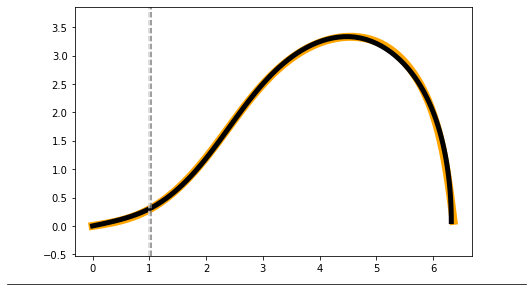

1 6


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 50000/50000 [05:35<00:00, 149.15it/s]


sigma = 1, xF_sim = 6
xC = 2.981148600392193 
 FC = -0.14997164730666127 
 F_CL = -0.880581854324726


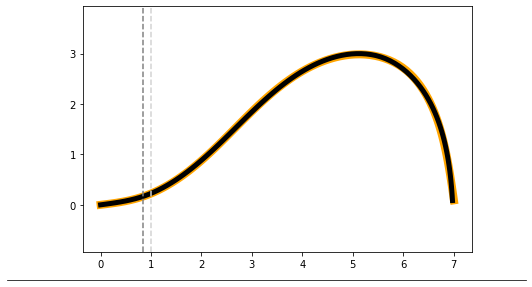

1 7


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 50000/50000 [04:16<00:00, 195.17it/s]


sigma = 1, xF_sim = 7
xC = 2.981148600392193 
 FC = -0.14997164730666127 
 F_CL = -0.6620873135523283


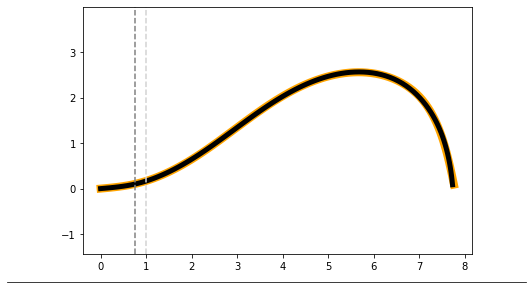

1 8


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 50000/50000 [04:45<00:00, 175.22it/s]


sigma = 1, xF_sim = 8
xC = 2.981148600392193 
 FC = -0.14997164730666127 
 F_CL = -0.47824885876468437


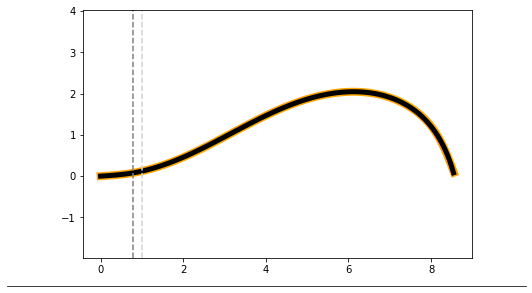

1 9


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 50000/50000 [04:44<00:00, 175.92it/s]


sigma = 1, xF_sim = 9
xC = 2.981148600392193 
 FC = -0.14997164730666127 
 F_CL = -0.299168388112518


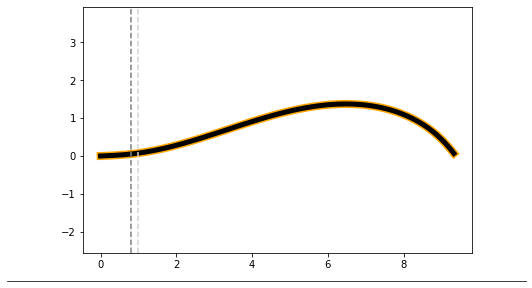

1.5 5


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 50000/50000 [05:21<00:00, 155.67it/s]


sigma = 1.5, xF_sim = 5
xC = 2.981148600392193 
 FC = -0.14997164730666127 
 F_CL = -0.9357388422999723


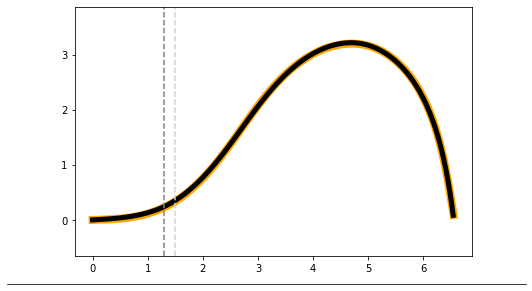

1.5 6


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 50000/50000 [06:13<00:00, 133.87it/s]


sigma = 1.5, xF_sim = 6
xC = 2.981148600392193 
 FC = -0.14997164730666127 
 F_CL = -0.6950333743222578


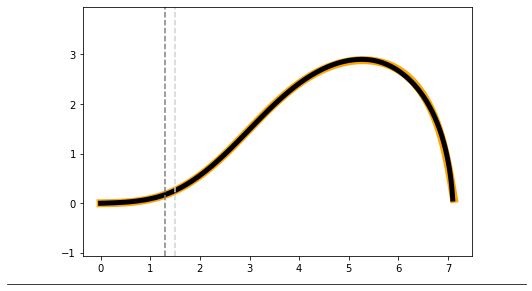

1.5 7


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 50000/50000 [05:25<00:00, 153.76it/s]


sigma = 1.5, xF_sim = 7
xC = 2.981148600392193 
 FC = -0.14997164730666127 
 F_CL = -0.5078302464922783


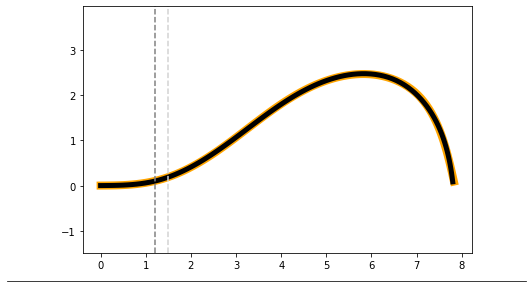

1.5 8


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 50000/50000 [05:15<00:00, 158.73it/s]


sigma = 1.5, xF_sim = 8
xC = 2.981148600392193 
 FC = -0.14997164730666127 
 F_CL = -0.35775108427319097


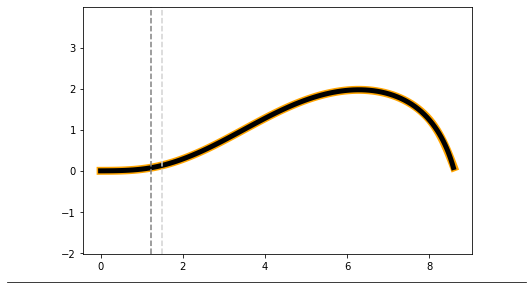

1.5 9


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 50000/50000 [05:23<00:00, 154.40it/s]


sigma = 1.5, xF_sim = 9
xC = 2.981148600392193 
 FC = -0.14997164730666127 
 F_CL = -0.21896563666093752


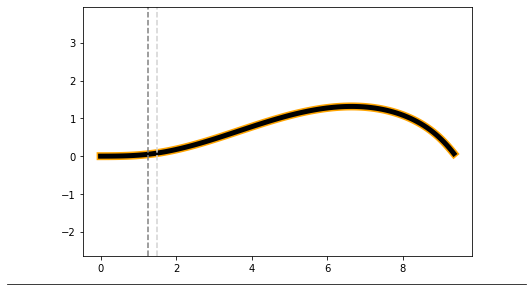

2 5


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 50000/50000 [05:39<00:00, 147.36it/s]


sigma = 2, xF_sim = 5
xC = 2.981148600392193 
 FC = -0.14997164730666127 
 F_CL = -0.5482521729680554


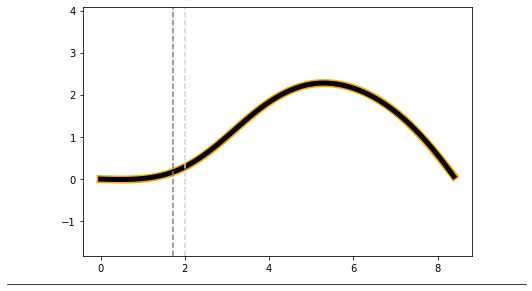

2 6


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 50000/50000 [05:12<00:00, 160.04it/s]


sigma = 2, xF_sim = 6
xC = 2.981148600392193 
 FC = -0.14997164730666127 
 F_CL = -0.575554084073582


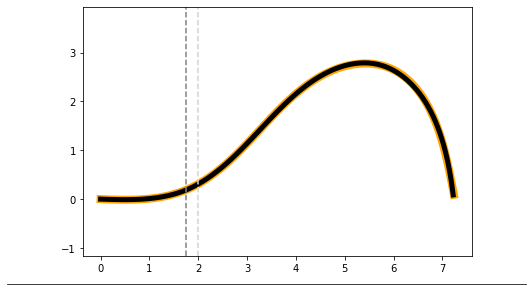

2 7


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 50000/50000 [04:57<00:00, 168.16it/s]


sigma = 2, xF_sim = 7
xC = 2.981148600392193 
 FC = -0.14997164730666127 
 F_CL = -0.4073409217445697


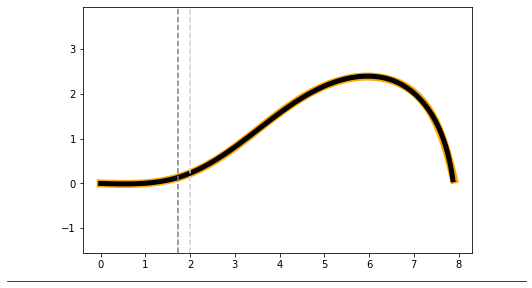

2 8


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 50000/50000 [05:08<00:00, 162.18it/s]


sigma = 2, xF_sim = 8
xC = 2.981148600392193 
 FC = -0.14997164730666127 
 F_CL = -0.2790310942749812


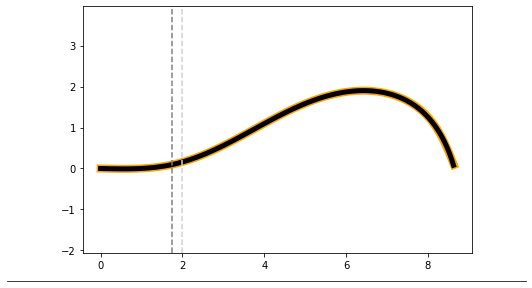

2 9


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 50000/50000 [04:50<00:00, 171.88it/s]


sigma = 2, xF_sim = 9
xC = 2.981148600392193 
 FC = -0.14997164730666127 
 F_CL = -0.16670672973427894


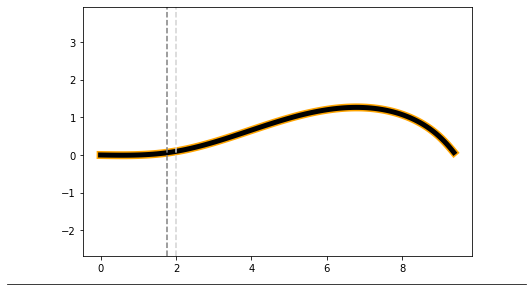

2.5 5


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 50000/50000 [05:16<00:00, 158.01it/s]


sigma = 2.5, xF_sim = 5
xC = 2.981148600392193 
 FC = -0.14997164730666127 
 F_CL = -0.46252186825100905


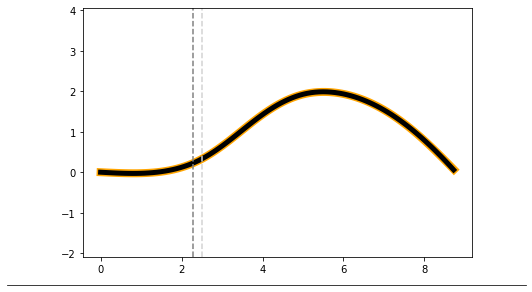

2.5 6


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 50000/50000 [05:10<00:00, 160.82it/s]


sigma = 2.5, xF_sim = 6
xC = 2.981148600392193 
 FC = -0.14997164730666127 
 F_CL = -0.5129305888552875


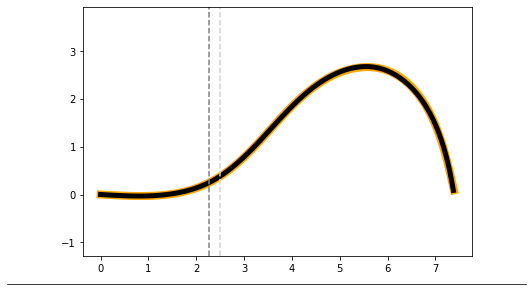

2.5 7


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 50000/50000 [05:05<00:00, 163.52it/s]


sigma = 2.5, xF_sim = 7
xC = 2.981148600392193 
 FC = -0.14997164730666127 
 F_CL = -0.3500034781692356


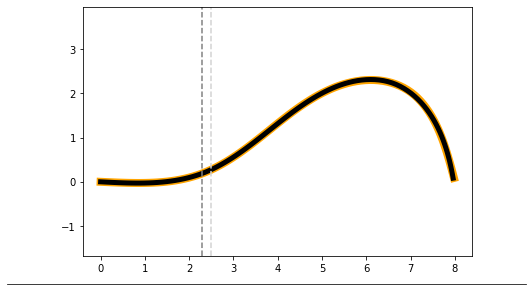

2.5 8


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 50000/50000 [04:58<00:00, 167.77it/s]


sigma = 2.5, xF_sim = 8
xC = 2.981148600392193 
 FC = -0.14997164730666127 
 F_CL = -0.2318404022323912


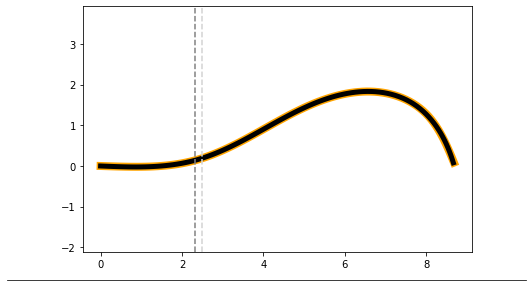

2.5 9


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 50000/50000 [04:36<00:00, 180.96it/s]


sigma = 2.5, xF_sim = 9
xC = 2.981148600392193 
 FC = -0.14997164730666127 
 F_CL = -0.13450764152332192


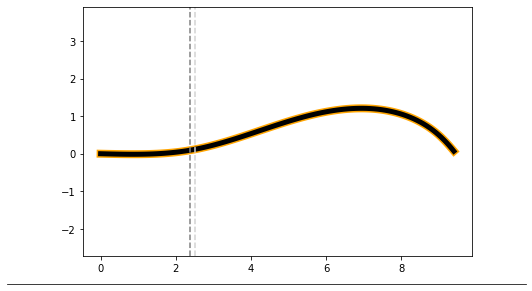

3 5


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 50000/50000 [05:30<00:00, 151.15it/s]


sigma = 3, xF_sim = 5
xC = 2.981148600392193 
 FC = -0.14997164730666127 
 F_CL = -0.7389788690111782


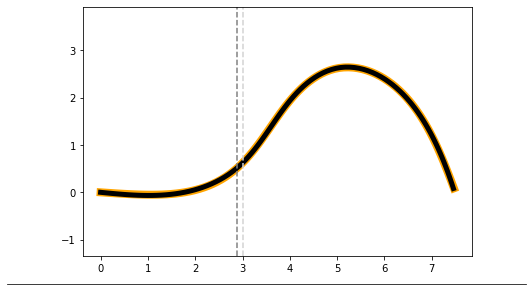

3 6


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 50000/50000 [04:38<00:00, 179.43it/s]


sigma = 3, xF_sim = 6
xC = 2.981148600392193 
 FC = -0.14997164730666127 
 F_CL = -0.5010148948798929


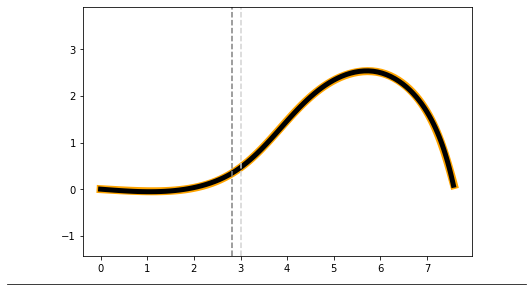

3 7


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 50000/50000 [04:41<00:00, 177.38it/s]


sigma = 3, xF_sim = 7
xC = 2.981148600392193 
 FC = -0.14997164730666127 
 F_CL = -0.33033410526717


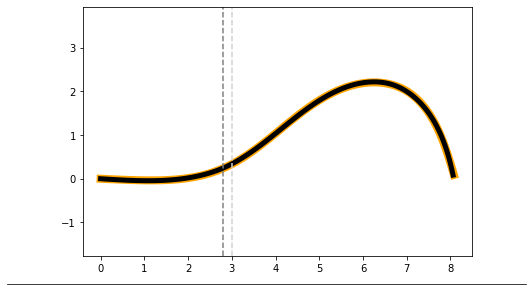

3 8


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 50000/50000 [03:50<00:00, 216.95it/s]


sigma = 3, xF_sim = 8
xC = 2.981148600392193 
 FC = -0.14997164730666127 
 F_CL = -0.21131944515583218


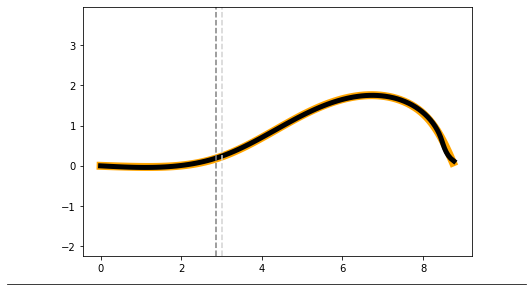

3 9


  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 50000/50000 [04:05<00:00, 203.31it/s]


sigma = 3, xF_sim = 9
xC = 2.981148600392193 
 FC = -0.14997164730666127 
 F_CL = -0.1187501700267553


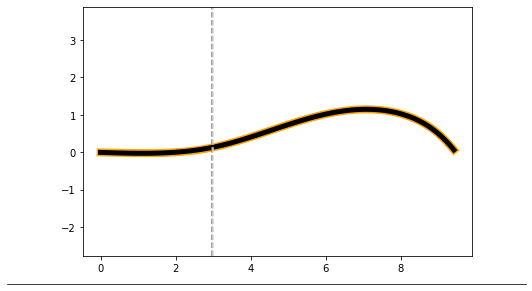

In [82]:
#### PARAMETER INFERENCE TO FIT MODEL TO SIMULATED DATA

Fy = 1.0
Fext_sim = Fy

df_fin_point_force = pd.DataFrame()
df = pd.read_pickle("discreteCL_modeling.pkl")

sigma_xF = 0.5

n_dim = 8
n_keep = 2*n_dim
n_steps_explore = 1000
n_steps_full = 50000
cols = ['Fx', 'Mk', 'Fy', 'theta0', 'F', 'xF', 'xC', 'FC']


for sigma in sigma_ls:
    for xF_sim in xF_ls:
        print(sigma,xF_sim)
        df_found = df.loc[(df['L_contour'] == L_contour) & (df['Fy'] == Fext_sim) & (df['xF'] == xF_sim) & (df['num_sites'] == num_sites)
                          & (df['CL_tot'] == CL_tot) & (df['amp2offset'] == amp2offset) & (df['sigma'] == sigma)
                          & (df['CL_kv'] == CL_kv) & (df['distribution'] == distribution) & (df['spacing'] == spacing)]

        x_ls = df_found["x_vals"].values[0]
        y_ls = df_found["y_vals"].values[0]
        M_ls = df_found["M_vals"].values[0]
        CL_pos = df_found["CL_pos_vals"].values[0]  
        F_CL = df_found["fCLy_val"].values[0]
        
        x_dat = x_ls[::10]
        y_dat = y_ls[::10]
        theta0 = np.arctan2(y_dat[3]-y_dat[0], x_dat[3]-x_dat[0])
        theta_peak = np.arctan(y_dat[y_dat==y_dat.max()]/x_dat[y_dat==y_dat.max()])[0]
        
        # ----------------- Parameter inference: MCMC ----------------- #
        fig, ax = plt.subplots()

        Mk_zero = True
        Mk_init = 0.0
        theta0_init = theta_peak
        xF_init = xF_sim
        xC_init = 1.0
        FC_init = 0.01

        end_to_end = np.inf
        args = (x_dat, y_dat, xF_sim, sigma_xF, Mk_zero, end_to_end)

        p_init_set = []
        for Fext_init in np.logspace(-1, 0.5, 5):
            for Fx_init in -np.linspace(0, 1, 4)*Fext_init:
                for Fy_init in -np.linspace(0, 0.5, 4)*Fext_init:
                    for xC_init in [1.0, 2.0]:
                        for FC_init in [0.01, 0.05]:

                            p_init = np.array([Fx_init, Mk_init, Fy_init, theta0_init, Fext_init, xF_init, \
                                               xC_init, FC_init])

                            if logpost_exact(p_init, *args) != -np.inf:
                                p_init_set.append(p_init)

        if len(p_init_set) < 2*n_dim:
            for i in range(2*n_dim-len(p_init_set)):
                p_init_set.append(p_init_set[i])

        eps = 1e-2*np.random.rand(len(p_init_set), n_dim)
        p_init_set = np.array(p_init_set) + eps

        n_walkers = len(p_init_set)
        sampler = emcee.EnsembleSampler(n_walkers, n_dim, logpost_exact, args=args, threads=3)
        _ = sampler.run_mcmc(p_init_set, n_steps_explore, progress=True)
        df_mcmc = sampler_to_dataframe(sampler, columns=cols)



        args = (x_dat, y_dat, xF_sim, sigma_xF, Mk_zero, end_to_end)

        p_init_subset = give_top_chain(df_mcmc, n_dim, n_keep)
        n_walkers = len(p_init_subset)
        sampler = emcee.EnsembleSampler(n_walkers, n_dim, logpost_exact, args=args, threads=3)
        _ = sampler.run_mcmc(p_init_subset, n_steps_full, progress=True)
        df_mcmc = sampler_to_dataframe(sampler, columns=cols)


        p_opt_mcmc = df_mcmc[df_mcmc['lnprob']==df_mcmc['lnprob'].max()].values[0][:-2]
        deflect_arrays, deflect_numbers = deflection_exact_FC(p_opt_mcmc, x_dat, y_dat, Mk_zero)
        x_mod_mcmc = deflect_arrays["x_mod"]
        y_mod_mcmc = deflect_arrays["y_mod"]
        M_mod_mcmc = deflect_arrays["M_mod"]
        xF = deflect_numbers['xF']
        yF = deflect_numbers['yF']
        thetaF = deflect_numbers['thetaF']

        _, ind_pairs = distances_pair_min(x_dat, y_dat, x_mod_mcmc, y_mod_mcmc)
        ind_pairs = ind_pairs.astype('int')
        x_mod_mcmc_truncated = x_mod_mcmc[:ind_pairs[-1]+1]
        y_mod_mcmc_truncated = y_mod_mcmc[:ind_pairs[-1]+1]
        M_mod_mcmc_truncated = M_mod_mcmc[:ind_pairs[-1]+1]

#         print('Mk≠0: Fx, Mk, Fy, theta0, F, xF, xC, FC')
#         print([np.round(x,3) for x in p_opt_mcmc])


        Fx, Mk, Fy, theta0, Fext, xF, xC, FC = p_opt_mcmc
        
        if Mk_zero:
            Mk = 0.0

        plt.plot(x_dat,y_dat, color="orange", lw = 8)
        plt.plot(x_mod_mcmc_truncated, y_mod_mcmc_truncated, color='k', lw = 5)
        plt.axvline(xC, color='grey', ls="--")
        plt.axvline(sigma, color='lightgrey', ls="--")
        plt.axis("equal")

        plt.tight_layout()

        res = distances_pair_min_new(x_dat, y_dat, x_mod_mcmc_truncated, y_mod_mcmc_truncated)
        RMSE = np.sqrt(np.mean(res**2))
        gap_max = np.max(res)

        if show_details:
            print("RMSE: %.4f"%RMSE)
            print("Max gap: %.4f"%gap_max)
            
        print("sigma = %s, xF_sim = %s"%(sigma,xF_sim))
        print("xC = %s \n FC = %s \n F_CL = %s" %(xC_opt, FC_opt, F_CL))


        df_fin = df_fin.append({'L_contour':L_contour,
                                'Fext_sim':Fext_sim,
                                'xF_sim':xF_sim,
                                'num_sites':num_sites,
                                'CL_tot':CL_tot,
                                'amp2offset': amp2offset,
                                'sigma': sigma,
                                'CL_kv': CL_kv,
                                'F_CL': F_CL,
                                'distribution': distribution,
                                'spacing':spacing,                            
                                'x_dat': x_dat,
                                'y_dat': y_dat,
                                
                                'x_mod': x_mod_mcmc_truncated,
                                'y_mod': y_mod_mcmc_truncated,
                                'M_mod': M_mod_mcmc_truncated,
                                
                                'Fx': Fx,
                                'Mk': Mk,
                                'Fy': Fy,
                                'theta0': theta0,
                                'Fext': Fext,
                                'thetaF': thetaF,
                                'xF': xF,
                                'yF': yF,
                                'xC': xC,
                                'FC': FC,

                                'gap_max': gap_max, 
                                'RMSE': RMSE}, ignore_index=True)        

        line = plt.Line2D([-0.1,1.1], [0,0], transform=fig.transFigure, color="black", lw = 0.75)
        fig.add_artist(line)
        plt.show()

In [83]:
pkl_name = 'validating_effpointforce.pkl'
df_fin.to_pickle(pkl_name)

sigma = 3
xC = 2.893897004119752


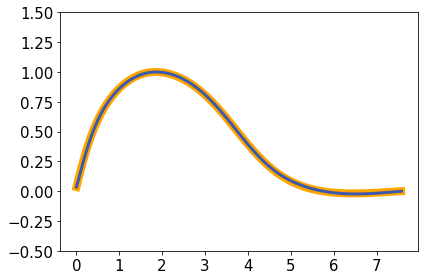

In [161]:

L_contour = 10
Fy = 1.0
xF_ls = [6]
num_sites = 1000
CL_tot = 100
amp2offset = 1e6
sigma_ls = [3]
CL_kv = 0.1 #np.linspace(0,0.1,10)
distribution = 'step'
spacing = 'deterministic' # 'deterministic' or 'random'
sigma_xF = 0.5
colors = pl.cm.Greens(np.linspace(0.15,1,len(sigma_ls)))


# kfiber_length_arr = np.zeros(len(xF_ls))
# chrom_star_dist_arr = np.zeros(len(xF_ls))
# chrom_needle_dist_arr = np.zeros(len(xF_ls))
# x_star_array = np.zeros(len(xF_ls)) 
# x_star_arrays = []
plt.figure(figsize=(6,4))

for n,sigma in enumerate(sigma_ls):
    for i,xF in enumerate(xF_ls):
        df_found = df_fin.loc[(df_fin['L_contour'] == L_contour) & (df_fin['Fy'] == Fy) & (df_fin['xF'] == xF) & (df_fin['num_sites'] == num_sites) 
                          & (df_fin['CL_tot'] == CL_tot) & (df_fin['amp2offset'] == amp2offset) & (df_fin['sigma'] == sigma)
                          & (df_fin['CL_kv'] == CL_kv) & (df_fin['distribution'] == distribution) & (df_fin['spacing'] == spacing)]

        x_dat = df_found["x_dat"].values[0]
        y_dat = df_found["y_dat"].values[0]
        x_mod = df_found["x_mod"].values[0]
        y_mod = df_found["y_mod"].values[0]
        
        xC = df_found['xC'].values[0]
        FC = df_found['FC'].values[0]
        print("sigma = %s"%sigma)
        print("xC = %s"%xC)

        y_dat = np.flip(y_dat)
        x_dat = x_dat[-1] - x_dat[0] - np.flip(x_dat)
        y_mod = np.flip(y_mod)
        x_mod = x_mod[-1] - x_mod[0] - np.flip(x_mod)
        y_dat = y_dat / np.max(y_dat)
        y_mod = y_mod / np.max(y_mod)

        y_interp = interp1d(x_mod,y_mod)
        
        xF = x_mod[-1] - x_mod[0] - xF
        yF = y_interp(xF)
        xC_flipped = x_mod[-1] - x_mod[0] - xC
        sigma = x_mod[-1] - x_mod[0] - sigma
        
        plt.plot(x_dat, y_dat, color = 'orange', lw = 8)
        plt.plot(x_mod, y_mod, color = '#3D59AB', lw = 3)
#         plt.quiver(xF,y_interp(xF), 0,Fy,color='gold',scale=8,zorder=10)
#         plt.quiver(xC_flipped,y_interp(xC_flipped),0,-FC,zorder=10,scale=8,color="red")
#         plt.axvline(sigma,color='k', ls='--', lw = 0.5)
        plt.ylim(-0.5,1.5)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        # plt.axis("equal")
        plt.tight_layout()
        plt.savefig("fig_outputs/eff_pointforce_validation_example.pdf")
        plt.show()
        

sigma = 3


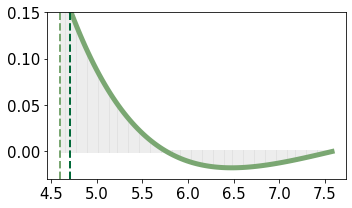

In [163]:
# kfiber_length_arr = np.zeros(len(xF_ls))
# chrom_star_dist_arr = np.zeros(len(xF_ls))
# chrom_needle_dist_arr = np.zeros(len(xF_ls))
# x_star_array = np.zeros(len(xF_ls)) 
# x_star_arrays = []
plt.figure(figsize=(5,3))
CL_x,CL_y=[],[]
for n,sigma in enumerate(sigma_ls):
    print("sigma = %s"%sigma)
    for i,xF in enumerate(xF_ls):
        df_found = df.loc[(df['L_contour'] == L_contour) & (df['Fy'] == Fy) & (df['xF'] == xF) & (df['num_sites'] == num_sites) 
                          & (df['CL_tot'] == CL_tot) & (df['amp2offset'] == amp2offset) & (df['sigma'] == sigma)
                          & (df['CL_kv'] == CL_kv) & (df['distribution'] == distribution) & (df['spacing'] == spacing)]

        x_ls = df_found["x_vals"].values[0]
        y_ls = df_found["y_vals"].values[0]
        M_ls = df_found["M_vals"].values[0]
        CL_pos = df_found["CL_pos_vals"].values[0]  
        
        # flip profile
        L = x_ls[-1] - x_ls[0]
        y_ls = np.flip(y_ls)
        x_ls = L - np.flip(x_ls)
        y_ls = y_ls / np.max(y_ls)
        xF = L - xF
        y_interp = interp1d(x_ls,y_ls)
        yF = y_interp(xF)
        
        
        # Normalize the magnitude of deflection
        y_ls = y_ls / np.max(y_ls)

        # Plot profile
        for i in range(0,len(CL_pos),1):
            if CL_pos[i] <= x_ls[-1]:
                CL_x.append(L - CL_pos[i])
                CL_y.append(y_interp(L - CL_pos[i]))
                
#                 plt.scatter(L - CL_pos[i],y_interp(L - CL_pos[i]), s = 15, color='#28a8e0', zorder=10)
                plt.plot([L - CL_pos[i],L - CL_pos[i]],[0,y_interp(L - CL_pos[i])], lw=3, color='lightgray', zorder=1,alpha=0.4)

# plt.plot(CL_x,CL_y,c='#7AA772', lw=10,alpha=0.3)
plt.plot(CL_x,CL_y,c='#7AA772', lw=5)
plt.axvline(L - xC,color='#006938', ls='--', lw = 2)
plt.axvline(L - sigma,color='#7AA772', ls='--', lw = 2)
# plt.xlim(5,7.5)
plt.ylim(-0.03,0.15)
plt.yticks([0,0.05,0.1,0.15])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig("fig_outputs/4b_inset.pdf")
plt.show()

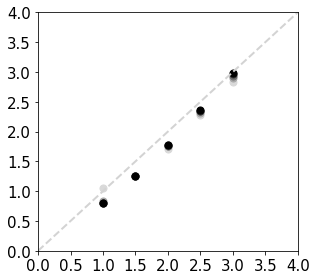

0.1807776799432318 0.07186410665415006 0.01855523255077312


In [158]:
#### SIMULATION PARAMETER INPUTS
L_contour = 10
Fy = 1.0
xF_ls = [5,6,7,8,9]
num_sites = 1000
CL_tot = 100
amp2offset = 1e6
sigma_ls = [1,1.5,2,2.5,3]
CL_kv = 0.1 #np.linspace(0,0.1,10)
distribution = 'step'
spacing = 'deterministic' # 'deterministic' or 'random'

plt.figure(figsize=(4.5,4))
colors = pl.cm.Greys(np.linspace(0.25,1,len(xF_ls)))

diff_ls = []

for i,xF in enumerate(xF_ls):
    for sigma in sigma_ls:
        df_found = df_fin.loc[(df_fin['xF'] == xF) & (df_fin['sigma'] == sigma)]
        xC = df_found['xC'].values[0]
        FC = df_found['FC'].values[0]
        diff_ls.append(abs(sigma-xC))

#         plt.scatter(sigma,xC, s=60, color='white',edgecolor='k')
        plt.scatter(sigma,xC, s=50, color=colors[i])
plt.plot([0,4],[0,4],color="lightgrey",lw = 2, ls="--")
# plt.xlabel("sigma")
# plt.ylabel("xC")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(0,4)
plt.xlim(0,4)
# plt.axis("equal")
plt.tight_layout()
plt.savefig("fig_outputs/sigma_vs_xC.pdf")
plt.show()


print(np.mean(diff_ls),np.std(diff_ls),np.std(diff_ls)/np.sqrt(15))

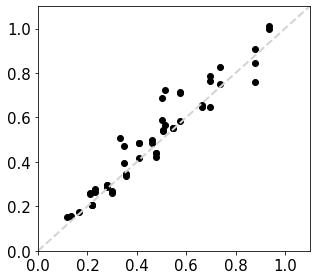

In [159]:
plt.figure(figsize=(4.5,4))
plt.scatter(-df_fin["F_CL"].values,df_fin["FC"].values,color="k" )
plt.plot([0,1.1],[0,1.1],color="lightgrey",lw = 2, ls="--")
plt.xlim(0,1.1)
plt.ylim(0,1.1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig("fig_outputs/FCL_vs_FC.pdf")

In [140]:
df_fin["FC"]

0     0.808218
1     0.758056
2    -0.581900
3     0.423810
4     0.265274
        ...   
65    0.749240
66    0.688216
67    0.507890
68    0.256884
69    0.150206
Name: FC, Length: 70, dtype: float64